#### Numerical Solution (Finite Differences Method)

The acoustic wave equation in 1D with constant density 

$$
\partial^2_t p(x,t) \ = \ c(x)^2 \partial_x^2 p(x,t) + s(x,t)
$$

with pressure $p$, acoustic velocity $c$, and source term $s$ contains two second derivatives that can be approximated with a difference formula such as

$$
\partial^2_t p(x,t) \ \approx \ \frac{p(x,t+dt) - 2 p(x,t) + p(x,t-dt)}{dt^2} 
$$

and equivalently for the space derivative. Injecting these approximations into the wave equation allows us to formulate the pressure p(x) for the time step $t+dt$ (the future) as a function of the pressure at time $t$ (now) and $t-dt$ (the past). This is called an explicit scheme allowing the $extrapolation$ of the space-dependent field into the future only looking at the nearest neighbourhood.

We replace the time-dependent (upper index time, lower indices space) part by

$$
 \frac{p_{i}^{n+1} - 2 p_{i}^n + p_{i}^{n-1}}{\mathrm{d}t^2} \ = \ c^2 ( \partial_x^2 p) \ + s_{i}^n
$$

solving for $p_{i}^{n+1}$.

The extrapolation scheme is

$$
p_{i}^{n+1} \ = \ c_i^2 \mathrm{d}t^2 \left[ \partial_x^2 p \right]
+ 2p_{i}^n - p_{i}^{n-1} + \mathrm{d}t^2 s_{i}^n
$$

The  space derivatives are determined by 

$$
\partial_x^2 p \ = \ \frac{p_{i+1}^{n} - 2 p_{i}^n + p_{i-1}^{n}}{\mathrm{d}x^2}
$$

In [10]:
# Import Libraries 
# ----------------------------------------------
import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

# Sub-plot Configuration
# ----------------------
from matplotlib import gridspec 

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [39]:
# Parameter Configuration 
# -----------------------

nx   = 10000        # number of grid points in x-direction
xmax = 10000        # physical domain (m)
dx   = xmax/(nx-1)  # grid point distance in x-direction
c0   = 334.         # wave speed in medium (m/s)
isrc = int(nx/2)    # source location in grid in x-direction
ir   = isrc + 100          # receiver location in grid in x-direction
nt   = 1001         # maximum number of time steps
dt   = 0.0010       # time step
op   = 3            # Length of FD operator for 2nd space derivative (3 or 5) 
print(op, '- point operator')
# Source time function parameters
f0   = 25. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift

# Snapshot
idisp = 5 # display frequency
# CPL Stability Criterion
# --------------------------
eps = c0 * dt / dx #epsilon value (corrected May 3, 2020)

print('Stability criterion =', eps)

3 - point operator
Stability criterion = 0.33396660000000006


In [40]:
# Plot Source Time Function
# -------------------------

# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src  = -8. * (time - t0) * f0 * (np.exp(-1.0 * (4*f0) ** 2 * (time - t0) ** 2))


<IPython.core.display.Javascript object>


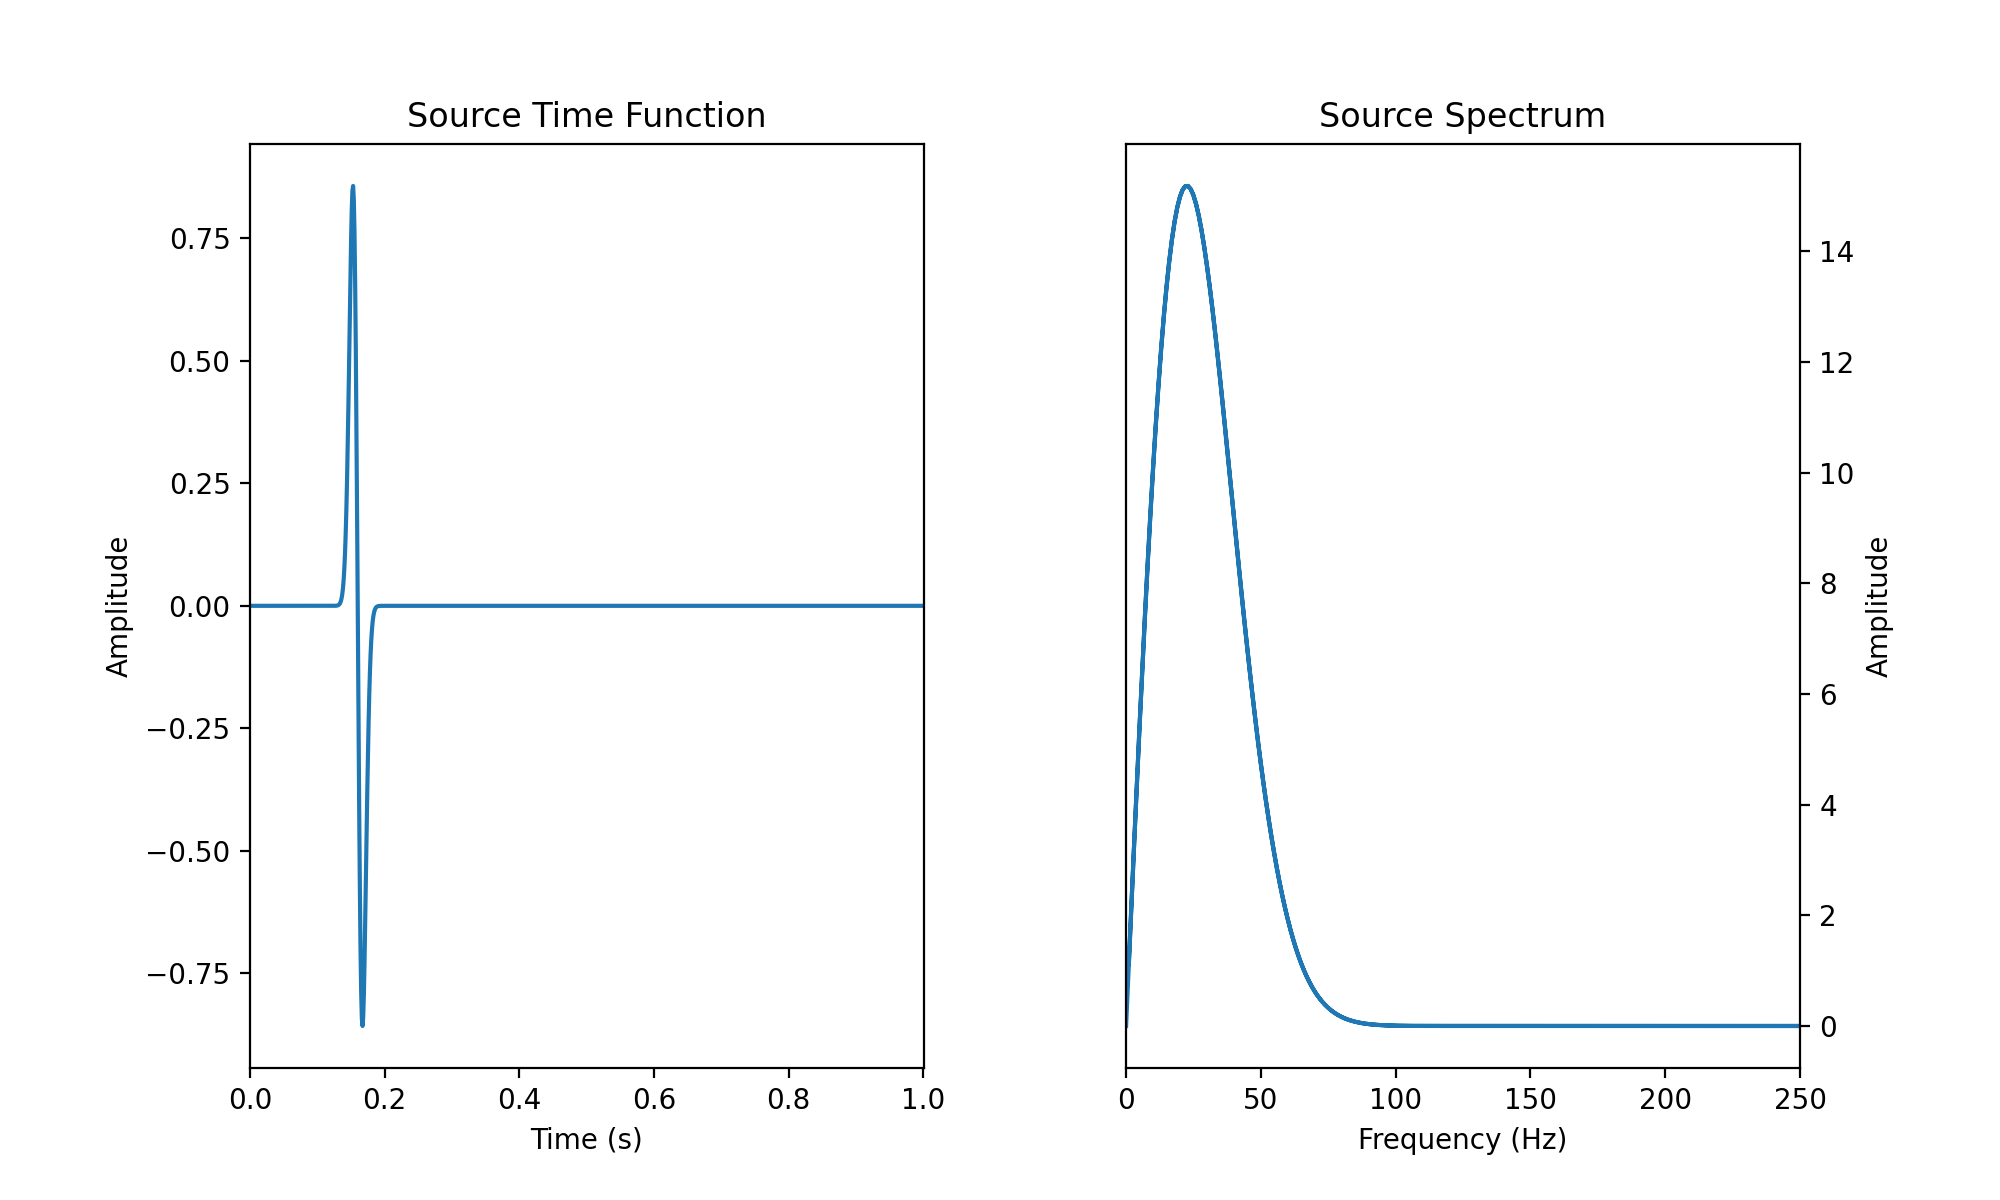

In [41]:
# Plot source time function

# Plot position configuration
# ---------------------------
plt.ion()
fig1 = plt.figure(figsize=(10, 6))
gs1  = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot source time function
# -------------------------
ax1  = plt.subplot(gs1[0])
ax1.plot(time, src) # plot source time function
ax1.set_title('Source Time Function')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot source spectrum
# --------------------
ax2  = plt.subplot(gs1[1])
spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt ) # time domain to frequency domain
ax2.plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax2.set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

<IPython.core.display.Javascript object>


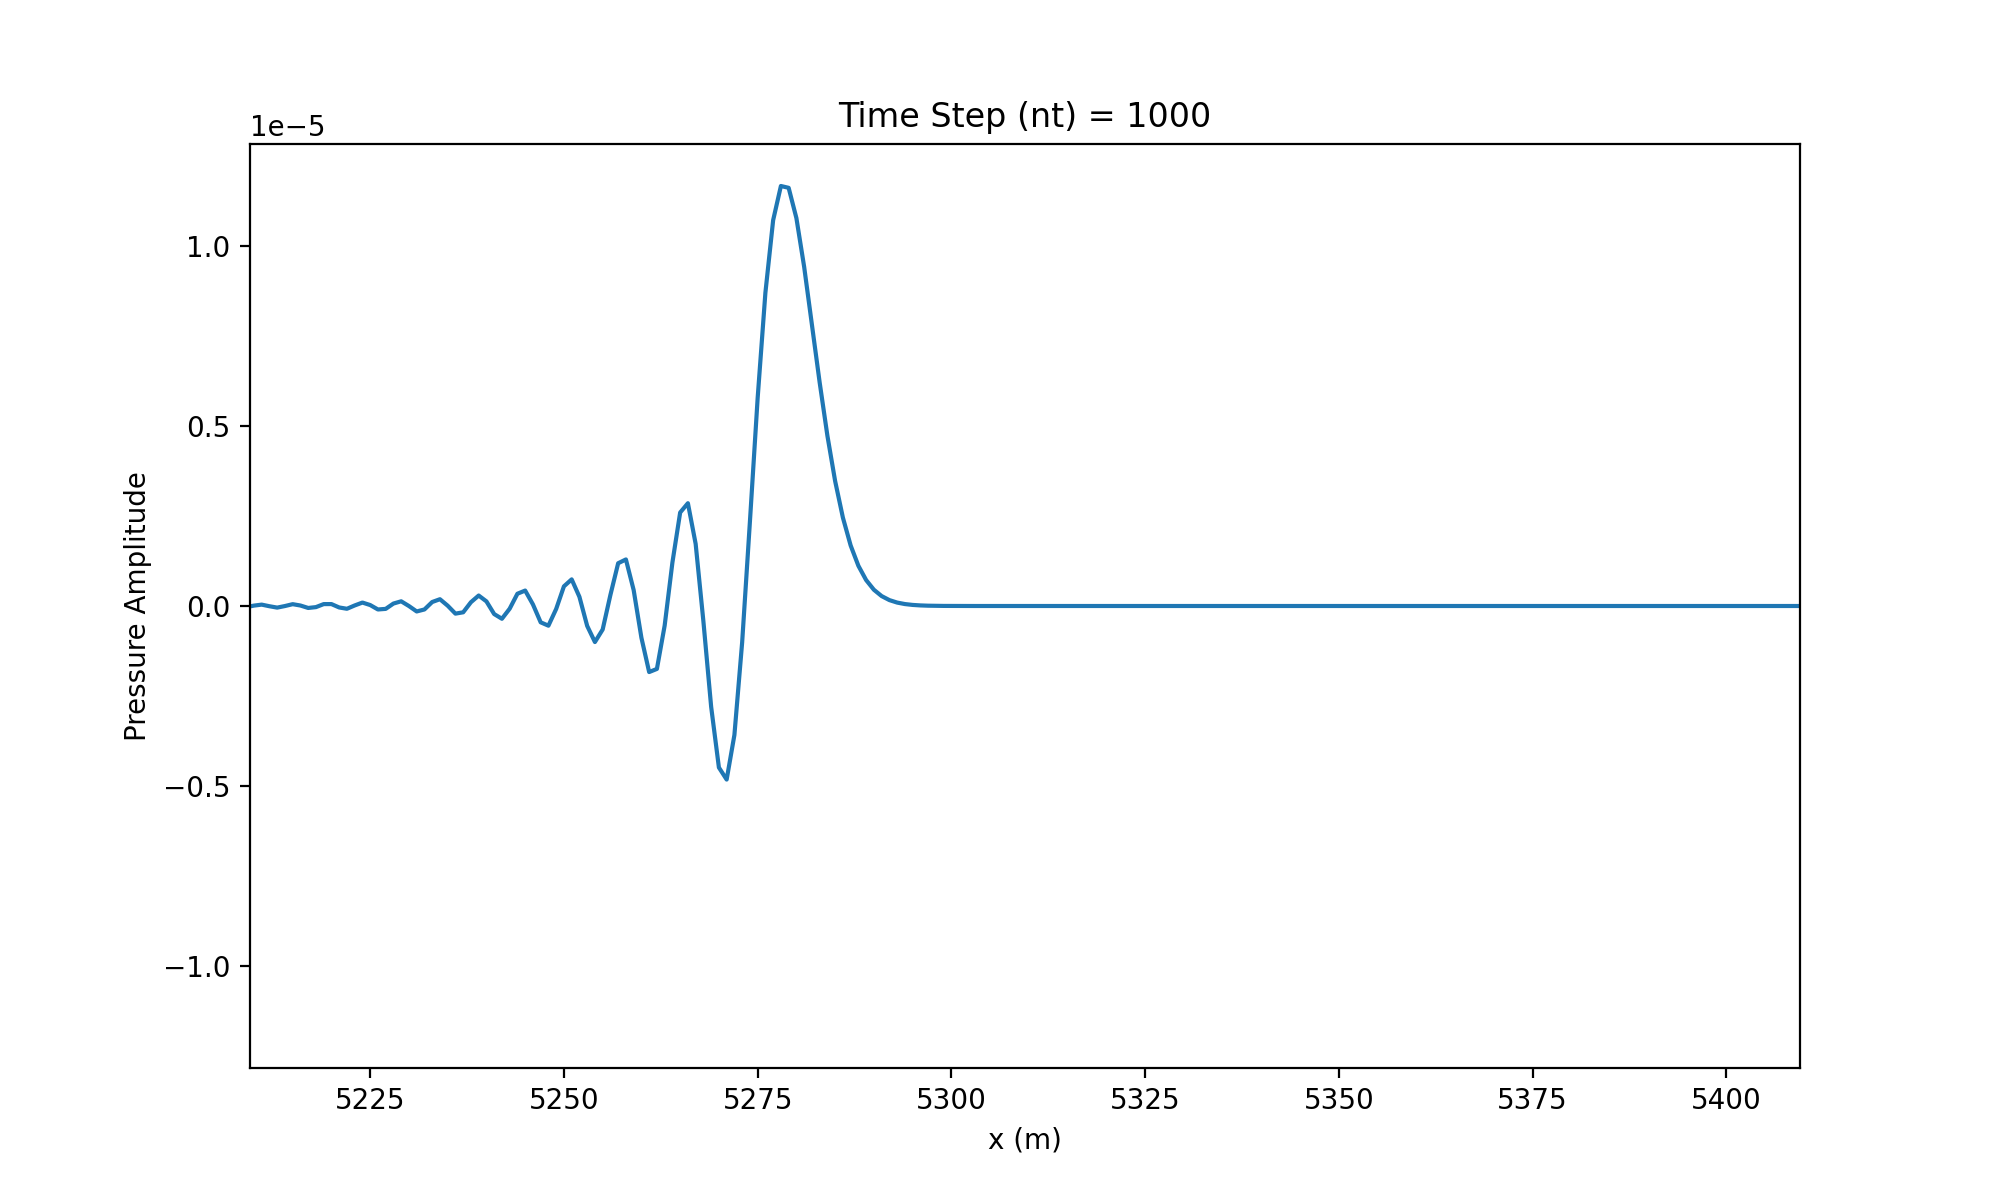

In [42]:
# Plot Snapshot & Seismogram 
# ---------------------------------------------------------------------------

# Initialize empty pressure
# -------------------------
p    = np.zeros(nx) # p at time n (now)
pold = np.zeros(nx) # p at time n-1 (past)
pnew = np.zeros(nx) # p at time n+1 (present)
d2px = np.zeros(nx) # 2nd space derivative of p

# Initialize model (assume homogeneous model)
# -------------------------------------------
c    = np.zeros(nx)
c    = c + c0       # initialize wave velocity in model

# Initialize coordinate
# ---------------------
x    = np.arange(nx)
x    = x * dx       # coordinate in x-direction


# Plot position configuration
# ---------------------------
plt.ion()
fig2  = plt.figure(figsize=(10, 6))
gs2   = gridspec.GridSpec(1,1,width_ratios=[1],hspace=0.3, wspace=0.3)

# Plot 1D wave propagation
# ------------------------
# Note: comma is needed to update the variable
ax3  = plt.subplot(gs2[0])
leg1,= ax3.plot(isrc, 0, 'r*', markersize=11) # plot position of the source in snapshot
#leg2,= ax3.plot(ir, 0, 'k^', markersize=8) # plot position of the receiver in snapshot
up31,= ax3.plot(p) # plot pressure update each time step
ax3.set_xlim(0, xmax)
ax3.set_ylim(-np.max(p), np.max(p))
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlabel('x (m)')
ax3.set_ylabel('Pressure Amplitude')
#ax3.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=10, numpoints=1)


plt.show()

In [43]:
# 1D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------

# Loop over time
for it in range(nt):

    # 2nd derivative in space
    for i in range(1, nx - 1):
        d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2


    # Time Extrapolation
    # ------------------
    pnew = 2 * p - pold + c ** 2 * dt ** 2 * d2px

    # Add Source Term at isrc
    # -----------------------
    # Absolute pressure w.r.t analytical solution
    pnew[isrc] = pnew[isrc] + src[it] / (dx) * dt ** 2
    
            
    # Remap Time Levels
    # -----------------
    pold, p = p, pnew
    
    # Plot pressure field
    # -------------------------------------
    if (it % idisp) == 0:
        ax3.set_title('Time Step (nt) = %d' % it)
        ax3.set_ylim(-1.1*np.max(abs(p)), 1.1*np.max(abs(p)))
        # plot around propagating wave
        window=100;xshift=25
        ax3.set_xlim(isrc*dx+c0*it*dt-window*dx-xshift, isrc*dx+c0*it*dt+window*dx-xshift)
        up31.set_ydata(p)
        plt.gcf().canvas.draw()

<IPython.core.display.Javascript object>


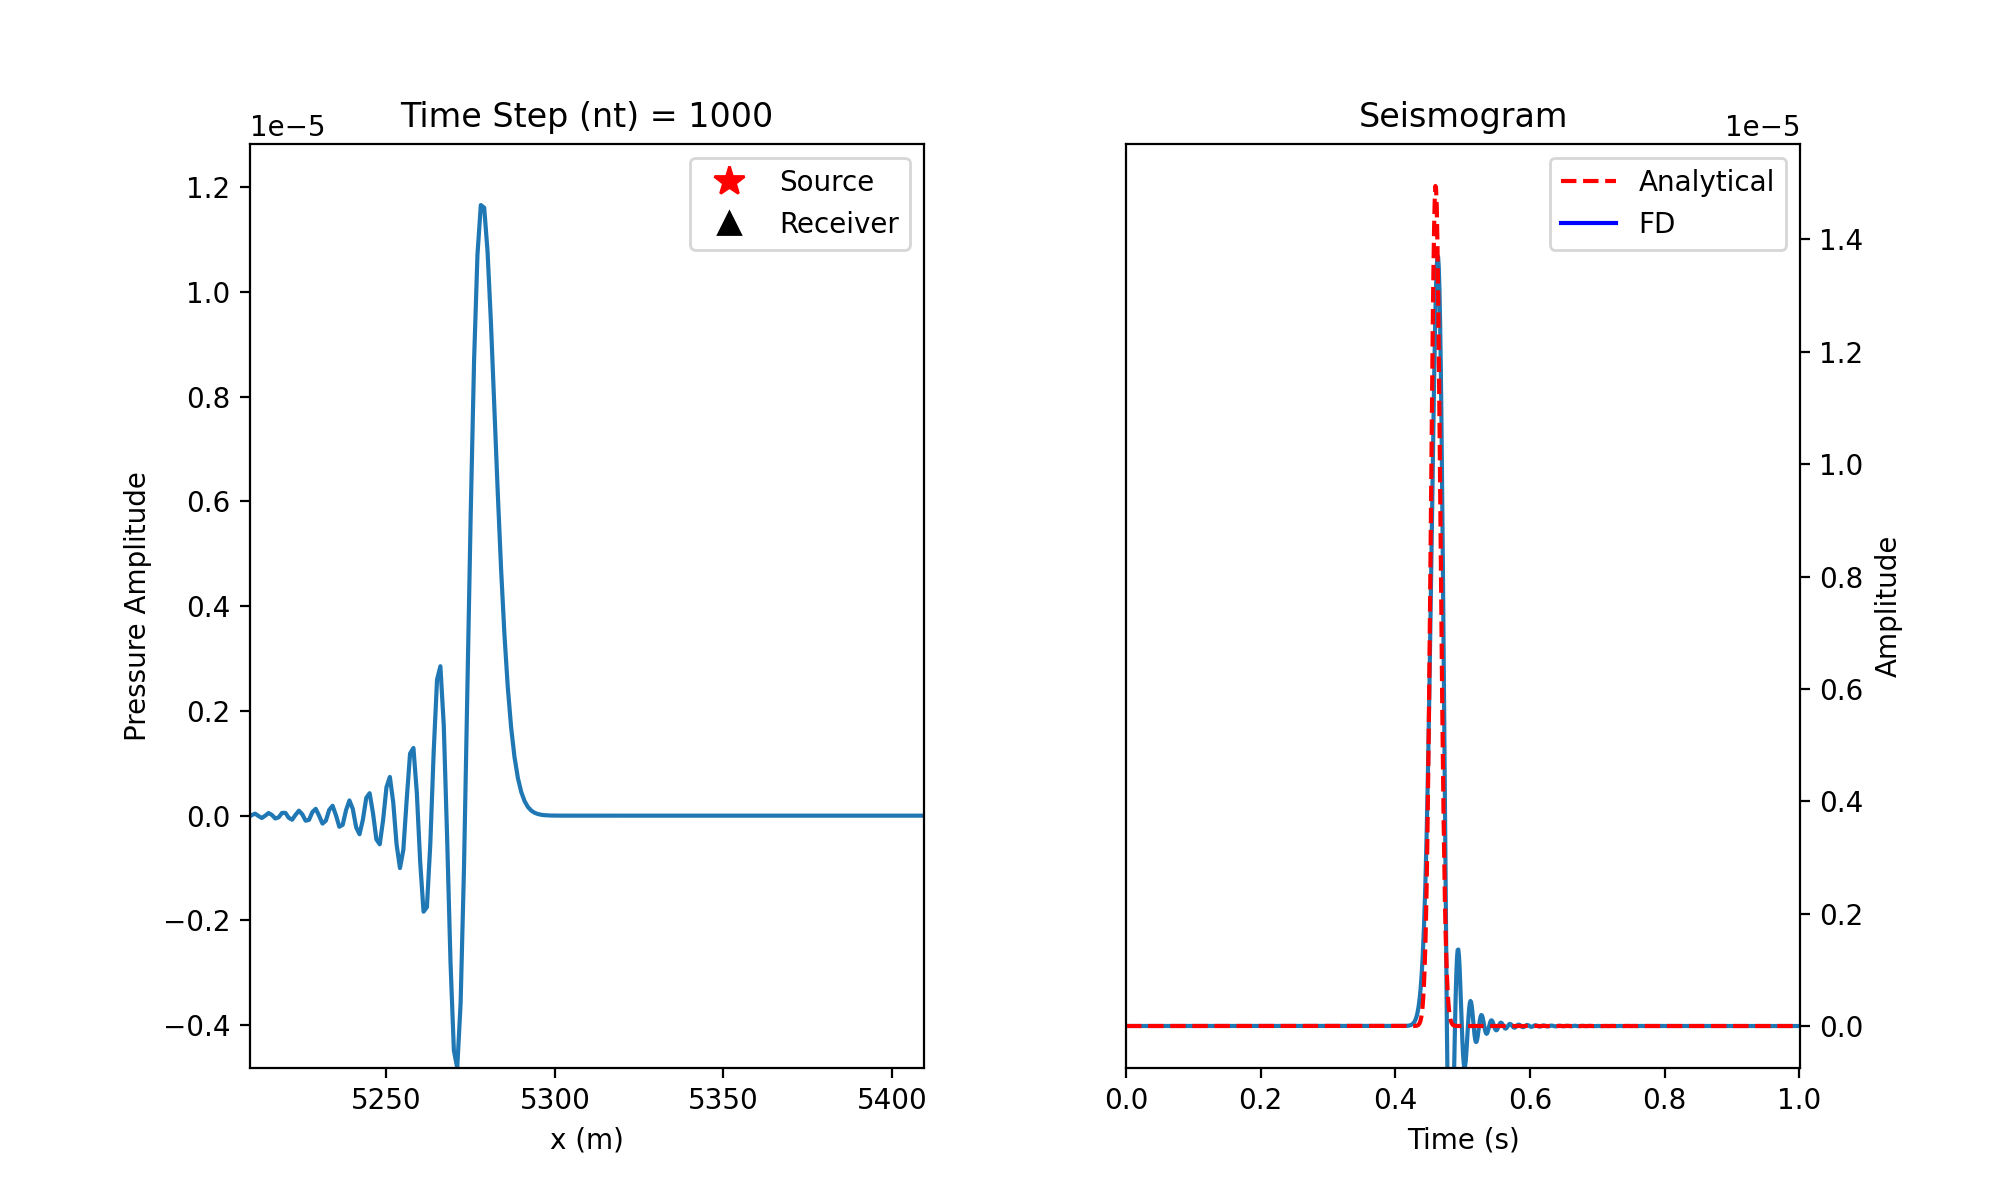

In [44]:
# Plot Snapshot & Seismogram - Run this code after simulation 
# ---------------------------------------------------------------------------

# Initialize empty pressure
# -------------------------
p    = np.zeros(nx) # p at time n (now)
pold = np.zeros(nx) # p at time n-1 (past)
pnew = np.zeros(nx) # p at time n+1 (present)
d2px = np.zeros(nx) # 2nd space derivative of p

# Initialize model (assume homogeneous model)
# -------------------------------------------
c    = np.zeros(nx)
c    = c + c0       # initialize wave velocity in model

# Initialize coordinate
# ---------------------
x    = np.arange(nx)
x    = x * dx       # coordinate in x-direction

# Initialize empty seismogram
# ---------------------------
seis = np.zeros(nt) 

# Analytical solution
# -------------------
G    = time * 0.
for it in range(nt): # Calculate Green's function (Heaviside function)
    if (time[it] - np.abs(x[ir] - x[isrc]) / c0) >= 0:
        G[it] = 1. / (2 * c0)
Gc   = np.convolve(G, src * dt)
Gc   = Gc[0:nt]
lim  = Gc.max() # get limit value from the maximum amplitude


# Plot position configuration
# ---------------------------
plt.ion()
fig2  = plt.figure(figsize=(10, 6))
gs2   = gridspec.GridSpec(1,2,width_ratios=[1, 1],hspace=0.3, wspace=0.3)

# Plot 1D wave propagation
# ------------------------
# Note: comma is needed to update the variable
ax3  = plt.subplot(gs2[0])
leg1,= ax3.plot(isrc, 0, 'r*', markersize=11) # plot position of the source in snapshot
leg2,= ax3.plot(ir, 0, 'k^', markersize=8) # plot position of the receiver in snapshot
up31,= ax3.plot(p) # plot pressure update each time step
ax3.set_xlim(0, xmax)
ax3.set_ylim(-np.max(p), np.max(p))
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlabel('x (m)')
ax3.set_ylabel('Pressure Amplitude')
ax3.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=10, numpoints=1)

# Plot seismogram 
# ---------------
# Note: comma is needed to update the variable
ax4  = plt.subplot(gs2[1])
leg3,= ax4.plot(0,0,'r--',markersize=1) # plot analytical solution marker
leg4,= ax4.plot(0,0,'b-',markersize=1) # plot numerical solution marker
up41,= ax4.plot(time, seis) # update recorded seismogram each time step
up42,= ax4.plot([0], [0], 'r|', markersize=15) # update time step position
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_xlim(time[0], time[-1])
ax4.set_title('Seismogram')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Amplitude')
ax4.legend((leg3, leg4), ('Analytical', 'FD'), loc='upper right', fontsize=10, numpoints=1)

plt.plot(time,Gc,'r--') # plot analytical solution
plt.show()

In [45]:
# 1D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------


# Calculate Partial Derivatives
# -----------------------------
for it in range(nt):
    if op==3: # use 3 point operator FD scheme
        for i in range(1, nx - 1):
            d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2

    if op==5: # use 5 point operator FD scheme
        for i in range(2, nx - 2):
            d2px[i] = (-1./12 * p[i + 2] + 4./3  * p[i + 1] - 5./2 * p[i] \
                       +4./3  * p[i - 1] - 1./12 * p[i - 2]) / dx ** 2

    # Time Extrapolation
    # ------------------
    pnew = 2 * p - pold + c ** 2 * dt ** 2 * d2px

    # Add Source Term at isrc
    # -----------------------
    # Absolute pressure w.r.t analytical solution
    pnew[isrc] = pnew[isrc] + src[it] / (dx) * dt ** 2
             
    # Remap Time Levels
    # -----------------
    pold, p = p, pnew
    
    # Output Seismogram
    # -----------------
    seis[it] = p[ir]
    
    # Plot pressure field
    # -------------------------------------
    # Snapshot
    idisp = 5 # display frequency
    if (it % idisp) == 0:
        ax3.set_title('Time Step (nt) = %d' % it)
        ax3.set_ylim(np.min(p), 1.1*np.max(p))
        # plot around propagating wave
        window=100;xshift=25
        ax3.set_xlim(isrc*dx+c0*it*dt-window*dx-xshift, isrc*dx+c0*it*dt+window*dx-xshift)
        up31.set_ydata(p)
        up41.set_ydata(seis)
        up42.set_data(time[it], seis[it])
        plt.gcf().canvas.draw()
    

### Stability (Courant criterion)
The Courant criterion is defined as 

$$
\epsilon = c \frac{ dt}{dx} \leq 1
$$

With this information we can calculate the maximum possible and stable time step.

### Analytical Solution

In the code below we present the analytical solution for the acoustic wave equation

$$
\partial_t^2 p(x,t) \ - \ c^2 \Delta p(x,t) \ = s(x,t)
$$

assuming constant velocity c and infinite space. Note that in 1D and 2D this equation is mathematically equivalent to the problem of SH wave propagation (i.e., shear waves polarised perpendicular to the plane through source and receiver). In 3D it is (only) descriptive of pressure (sound) waves.

Analytical solution for inhomogeneous partial differential equations (i.e., with non-zero source terms) are usually developed using the concept of Green's functions $G(x, t; x_0, t_0)$. Green's functions are the solutions to the specific partial differential equations for $\delta$-function as source terms evaluated at $(x, t)$ and activated at $(x_0, t_0)$. Thus, we seek solutions to 

$$
\partial_t^2 G(x,t;x_0, t_0) \ - \ c^2 \Delta G(x,t;x_0, t_0) \ = \delta (x-x_0) \delta (t-t_0)
$$

where $\Delta$ is the Laplace operator. We recall the definition of the  $\delta-$function as a generalised function with

$$
\delta(x) = \left\{
\begin{array}{ll}
	\infty &x=0 \\
	0 &x\neq 0 	
\end{array}
\right.
$$

and

$$
\int_{-\infty}^{\infty}\delta(x)dx\ = \ 1 \ , \   \int_{-\infty}^{\infty}f(x)\delta(x)dx\ = \ f(0) \ 
$$

When comparing numerical with analytical solutions the functions that - in the limit - lead to the $\delta-$function will become very important. An example is the boxcar function

$$
\delta_{bc}(x) = \left\{
\begin{array}{ll}
	1/dx &|x|\leq dx/2 \\
	0 &\text{elsewhere} 	
\end{array}
\right.
$$

fulfilling these properties as $dx\rightarrow0$. These functions are used to properly scale the source terms to obtain correct absolute amplitudes.

To describe analytical solutions for the acoustic wave equation we also make use of the unit step function, also known as the Heaviside function, defined as 

$$
H(x) = \left\{
\begin{array}{ll}
    0 &x<0 \\
	1 &x \geq 0 	
\end{array}
\right.
$$

The Heaviside function is the integral of the $\delta-$function (and vice-versa the $\delta$-function is defined as the derivative of the Heaviside function). In 2D case, the Green's function is

$$
G = \frac{1}{2\pi c^2}\frac{H(t-\frac{|r|}{c})}{\sqrt{t^2-\frac{r^2}{c^2}}}
$$

$$
r = \sqrt{x^2+y^2}
$$

A special situation occurs in 2D. An impulsive source leads to a waveform with a coda that decreases with time. This is a consequence of the fact that the source actually is a line source. From a computational point of view this is extremely important. Numerical solutions in 2D Cartesian coordinates cannot directly be compared to observations in which we usually have point sources.

### Numerical Solution (Finite Differences Method)

In 2D the constant-density acoustic wave equation is given by

$$
\partial^2_t{p}(x,z,t) \ = \ c^2 (\partial_x^2 p(x,z,t) + \partial_z^2 p(x,z,t)) \ + s(x,z,t)
$$

where the $z$-coordinate is chosen because in many applications the $x-z$ plane is considered a vertical plane with $z$ as depth coordinate. In accordance with the above developments we discretise space-time using

$$
p(x,z,t) \ \rightarrow \ p^n_{i,j} \ = \ p(n dt, i dx, j dz) \ .
$$

Using the 3-point operator for the 2nd derivatives in time leads us to the extrapolation scheme

$$
 \frac{p_{i,j}^{n+1} - 2 p_{i,j}^n + p_{i,j}^{n-1}}{dt^2} \ = \ c^2 ( \partial_x^2 p + \partial_z^2 p) \ + s_{i,j}^n
$$

where on the r.h.s. the space and time dependencies are implicitly assumed and the partial derivatives are approximated by

\begin{equation}
\begin{split}
\partial_x^2 p \ &= \ \frac{p_{i+1,j}^{n} - 2 p_{i,j}^n + p_{i-1,j}^{n}}{dx^2} \\ 
\partial_z^2 p \ &= \ \frac{p_{i,j+1}^{n} - 2 p_{i,j}^n + p_{i,j-1}^{n}}{dz^2}  \ . 
\end{split}
\end{equation}
Note that for a regular 2D grid $dz=dx$ 

### Analytical and Numerical Comparisons
The code below is given with a 3-point difference operator. Compare the results from numerical simulation with the 3-point operator with the analytical solution.

### High-order operators
Extend the code by adding the option to use a 5-point difference operator. The 5-pt weights are: 
$$
[-1/12, 4/3, -5/2, 4/3, -1/12]/dx^2
$$. 
Compare simulations with the 3-point and 5-point operators.

---

In [46]:
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

# Sub-plot Configuration
# ----------------------
from matplotlib import gridspec 
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [47]:
# Parameter Configuration 
# -----------------------

nx   = 500          # number of grid points in x-direction
nz   = nx           # number of grid points in z-direction
# Note: regular 2D grid, dz = dx
dx   = 1.           # grid point distance in x-direction
dz   = dx           # grid point distance in z-direction
c0   = 580.         # wave velocity in medium (m/s)
isx  = 200          # source location in grid in x-direction
isz  = isx          # source location in grid in z-direction
irx  = 300          # receiver location in grid in x-direction
irz  = irx          # receiver location in grid in z-direction
nt   = 502          # maximum number of time steps
dt   = 0.0010       # time step
f0   = 25. # dominant frequency of the source (Hz)
t0   = 2. / f0 # source time shift
op   = 3            # length of finite-difference operator (3 or 5)

print('Source frequency =', f0, 'Hz')

# CFL Stability Criterion
# -----------------------
eps  = c0 * dt / dx # epsilon value
print('Stability criterion =', eps)

# Initialize Empty Pressure
# -------------------------
p    = np.zeros((nz, nx)) # p at time n (now)
pold = np.zeros((nz, nx)) # p at time n-1 (past)
pnew = np.zeros((nz, nx)) # p at time n+1 (present)
d2px = np.zeros((nz, nx)) # 2nd space derivative of p in x-direction
d2pz = np.zeros((nz, nx)) # 2nd space derivative of p in z-direction

# Initialize Velocity Model (assume homogeneous model)
# ----------------------------------------------------
c    = np.zeros((nz, nx))
c    = c + c0             # initialize wave velocity in model

# Initialize Grid
x    = np.arange(nx)
x    = x * dx             # coordinate in x-direction
z    = np.arange(nz)
z    = z * dz             # coordinate in z-direction

# Initialize Empty Seismogram
# ---------------------------
seis = np.zeros(nt)

# Fontsize
# fs=20

Source frequency = 25.0 Hz
Stability criterion = 0.58


In [ ]:
# Initialize Source Time Function 
# -------------------------
# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src  = -8. * (time - t0) * f0 * (np.exp(-1.0 * (4*f0) ** 2 * (time - t0) ** 2))

In [48]:
# Initialize Source Time Function 
# -------------------------
# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src  = -8. * (time - t0) * f0 * (np.exp(-1.0 * (4*f0) ** 2 * (time - t0) ** 2))

<IPython.core.display.Javascript object>


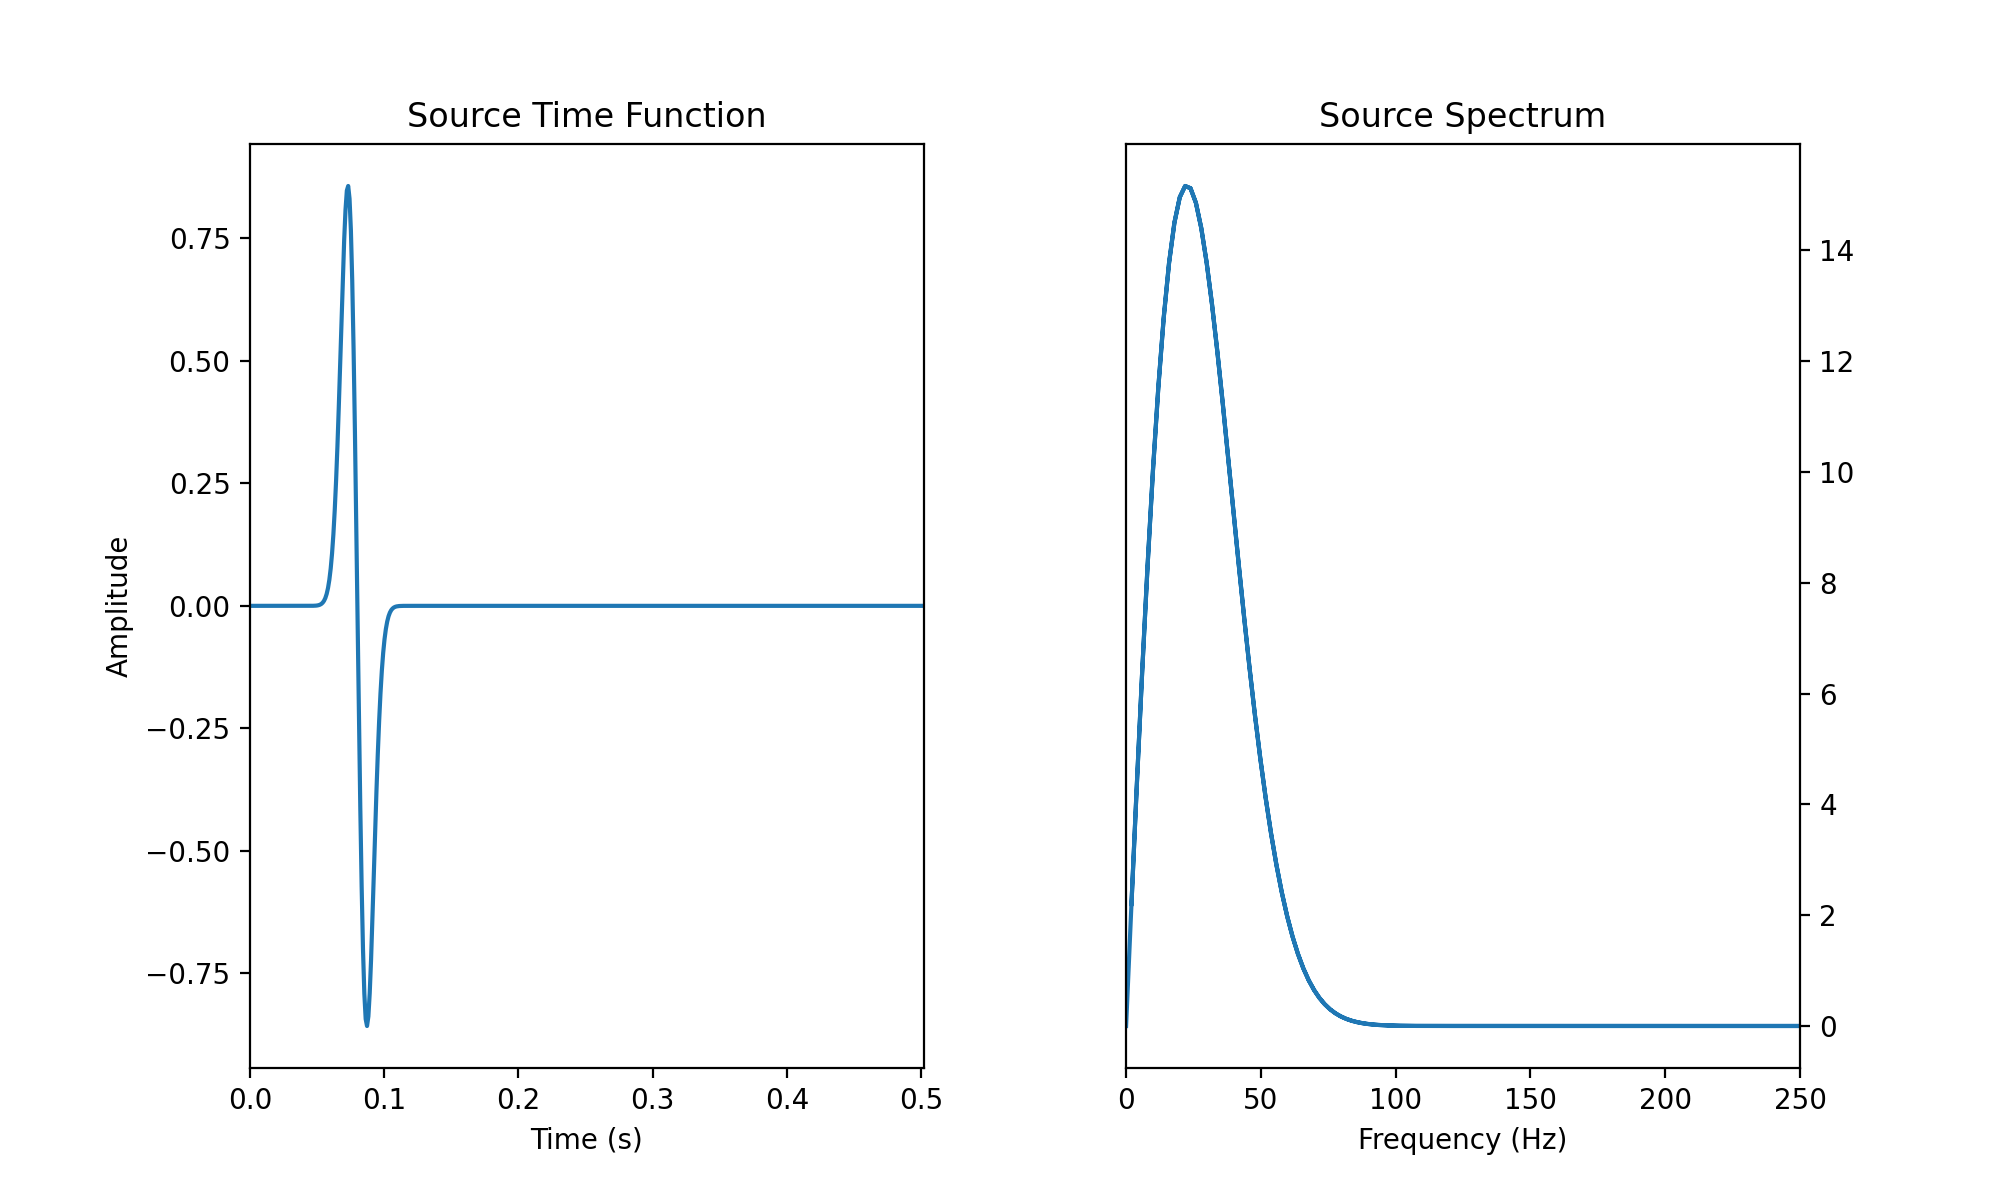

In [49]:
# Plot Source Time Function 
# -------------------------

# Plot Position Configuration
# ---------------------------
plt.ion()
fig1 = plt.figure(figsize=(10, 6))
gs1  = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot Source Time Function
# -------------------------
ax1  = plt.subplot(gs1[0])
ax1.plot(time, src) # plot source time function
ax1.set_title('Source Time Function')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot Source Spectrum
# --------------------
ax2  = plt.subplot(gs1[1])
spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt) # time domain to frequency domain
ax2.plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax2.set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

<IPython.core.display.Javascript object>


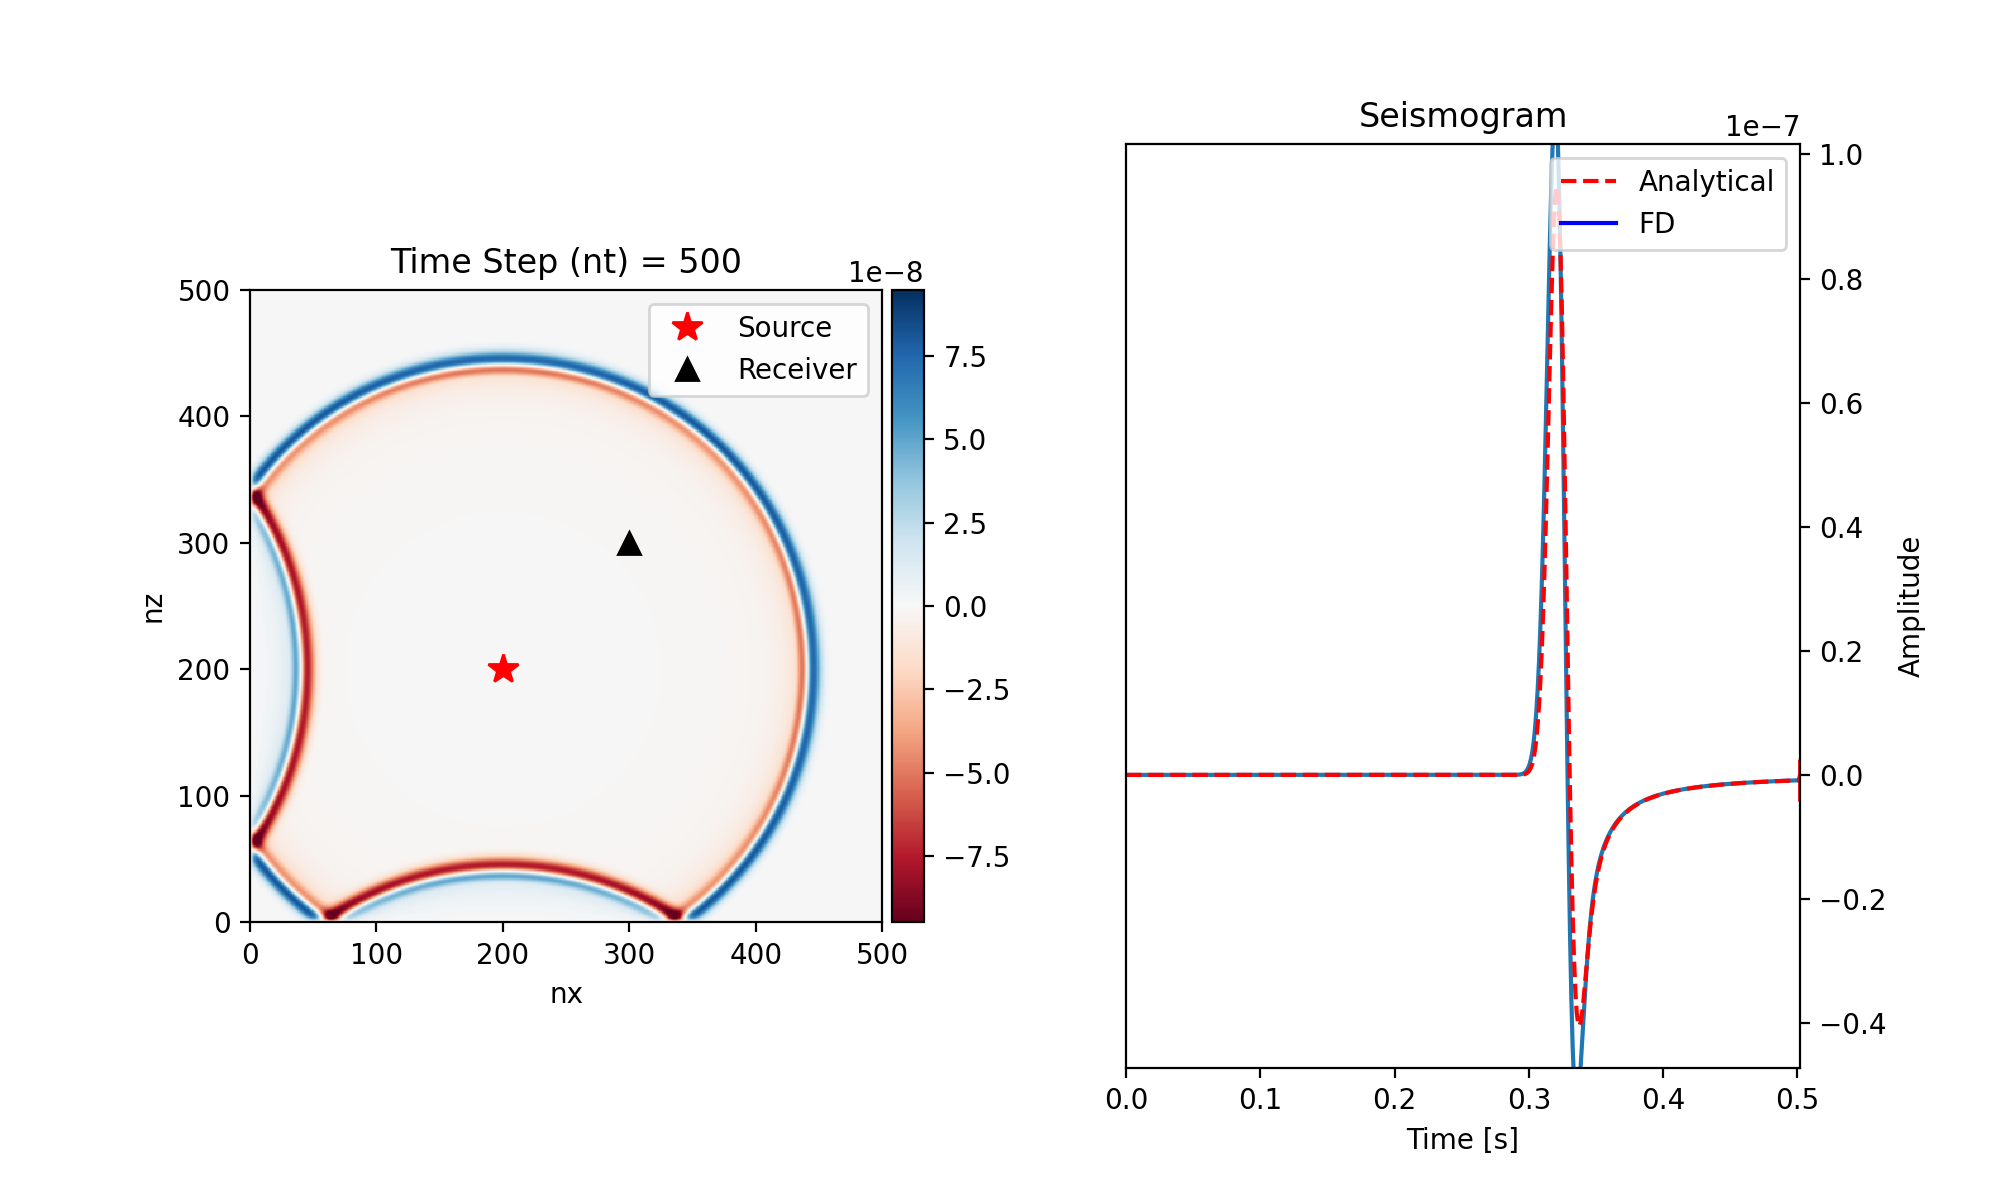

In [50]:
# Plot Snapshot & Seismogram (PLEASE RERUN THIS CODE AGAIN AFTER SIMULATION!) 
# ---------------------------------------------------------------------------

# Analytical Solution 
# -------------------
G    = time * 0.
r    = np.sqrt((x[isx] - x[irx]) ** 2 + (z[isz] - z[irz]) ** 2)

for it in range(nt): # Calculate Green's function
    #if ((time[it] - np.abs(x[irx] - x[isx]) / c0) >= 0):
    if ((time[it] - r/c0) >= 0):
        G[it] = (1. / (2 * np.pi * c0 ** 2)) \
        * (1. / np.sqrt((time[it] ** 2) - (r ** 2 / (c0 ** 2))))
Gc   = np.convolve(G, src * dt)
Gc   = Gc[0:nt]
lim  = Gc.max() # get limit value from maximum amplitude of analytical solution

# Plot Position Configuration
# ---------------------------
plt.ion()
fig2 = plt.figure(figsize=(10, 6))
gs2  = gridspec.GridSpec(1,2,width_ratios=[1,1],hspace=0.3, wspace=0.3)

# Plot 2D Wave Propagation
# ------------------------
# Note: comma is needed to update the variable
ax3  = plt.subplot(gs2[0])
leg1,= ax3.plot(isx, isz, 'r*', markersize=11) # plot position of the source in model
leg2,= ax3.plot(irx, irz, 'k^', markersize=8)  # plot position of the receiver in model
im3  = ax3.imshow(p, vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
div  = make_axes_locatable(ax3)
cax  = div.append_axes("right", size="5%", pad=0.05) # size & position of colorbar
fig2.colorbar(im3, cax=cax) # plot colorbar
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlim(0, nx)
ax3.set_ylim(0, nz)
ax3.set_xlabel('nx')
ax3.set_ylabel('nz')
ax3.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=10, numpoints=1)

# Plot Seismogram 
# ---------------
# Note: comma is needed to update the variable
ax4  = plt.subplot(gs2[1])
up41,= ax4.plot(time, seis) # update seismogram each time step
up42,= ax4.plot([0], [0], 'r|', markersize=15) # update time step position
ax4.set_xlim(time[0], time[-1])
ax4.set_title('Seismogram')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Amplitude')
leg3,= ax4.plot(0,0,'r--',markersize=1)
leg4,= ax4.plot(0,0,'b-',markersize=1)
ax4.legend((leg3, leg4), ('Analytical', 'FD'), loc='upper right', fontsize=10, numpoints=1)

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

plt.plot(time,Gc,'r--')
plt.show()

In [51]:
# 2D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------


# Calculate Partial Derivatives
# -----------------------------
for it in range(nt):
    if op == 3: # use 3 point operator FD scheme
        for i in range(1, nx - 1):
                d2px[i, :] = (p[i - 1, :] - 2 * p[i, :] + p[i + 1, :]) / dx ** 2 
        for j in range(1, nz - 1):
                d2pz[:, j] = (p[:, j - 1] - 2 * p[:, j] + p[:, j + 1]) / dz ** 2 
    
    if op == 5: # use 5 point operator FD scheme
        #-----------------------------------------------#
        #     IMPLEMENT 5 POINT OPERATOR CODE HERE!     #
        #-----------------------------------------------#
        pass
    
    # Time Extrapolation
    # ------------------
    pnew = 2 * p - pold + (c ** 2) * (dt ** 2) * (d2pz + d2px)
    
    # Add Source Term at isz and isx
    # ------------------------------
    # Absolute pressure w.r.t analytical solution
    pnew[isz, isx] = pnew[isz, isx] + src[it] / (dx * dz) * (dt ** 2) 
    
    # Remap Time Levels
    # -----------------
    pold, p = p, pnew
    
    # Output Seismogram
    # -----------------
    seis[it] = p[irz, irx]
    
    # Update Data for Wave Propagation Plot
    # -------------------------------------
    idisp = 5 # display frequency
    if (it % idisp) == 0:
        ax3.set_title('Time Step (nt) = %d' % it)
        ax3.imshow(p,vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
        up41.set_ydata(seis)
        up42.set_data(time[it], seis[it])
        # Uncoment for bigger fontsize - also uncoment the Fontsize in the cell parameters
        #for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label] +
        #     ax3.get_xticklabels() + ax3.get_yticklabels()):
        #     item.set_fontsize(fs)
        #for item in ([ax4.title, ax4.xaxis.label, ax4.yaxis.label] +
        #     ax4.get_xticklabels() + ax4.get_yticklabels()):
        #     item.set_fontsize(fs)
        plt.gcf().canvas.draw()